In [ ]:
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from glob import glob
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
import os
import copy
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import cv2
from tqdm import tqdm

In [2]:
class PadResize(object):
    def __init__(self,size):
        self.interpolation = Image.BILINEAR
        self.padding_v = [0, 0, 0]
        self.size = size
    def __call__(self, img):
        target_size = self.size
        padding_v = tuple(self.padding_v)
        interpolation = self.interpolation
        w, h = img.size
        if w > h:
            img = img.resize((int(target_size), int(h * target_size * 1.0 / w)), interpolation)
        else:
            img = img.resize((int(w * target_size * 1.0 / h), int(target_size)), interpolation)

        ret_img = Image.new("RGB", (target_size, target_size), padding_v)
        w, h = img.size
        st_w = int((ret_img.size[0] - w) / 2.0)
        st_h = int((ret_img.size[1] - h) / 2.0)
        ret_img.paste(img, (st_w, st_h))
        return ret_img

In [5]:
IMG_SIZE = (512, 512)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 3094
# model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=False)
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, NUM_CLASSES)
# model.load_state_dict(torch.load('../model/resnet50_1024_best.pth'))
# model.fc = nn.ReLU()

from senet import Baseline
model = Baseline(NUM_CLASSES,
                 1,
                 # 重要! ImageNet预训练权重下载地址为http://data.lip6.fr/cadene/pretrainedmodels/se_resnext50_32x4d-a260b3a4.pth
                 'se_resnext50_32x4d-a260b3a4.pth',
                 'bnneck',
                 'after',
                 'se_resnext50',
                 'imagenet'
                )

model.load_state_dict(torch.load('../model/se_resnext50_512_best_trick.pth'))

model.to(device)
model.eval()

Loading pretrained ImageNet model......


Baseline(
  (base): SENet(
    (layer0): Sequential(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    )
    (layer1): Sequential(
      (0): SEResNeXtBottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReL

In [8]:
feat_act = {}
def get_activation(name):
    def hook(model, input, output):
        feat_act[name] = output.detach()
    return hook
model.bottleneck.register_forward_hook(get_activation('avgpool'))

In [9]:
class TestImageDataset(torch.utils.data.Dataset):
    def __init__(self, image_fns, data_transforms):
        self.image_fns = image_fns
        self.transforms = data_transforms
    
    def __getitem__(self, index):
        fp = self.image_fns[index]
        fn = os.path.basename(fp)
        image = Image.open(fp).convert("RGB")
        
        # Preprocessing
        image = self.transforms(image)
        
        return image, fn
    
    def __len__(self):
        return len(self.image_fns)

import numpy as np
TEST_BATCH_SIZE = 32
d=2048
TEST_DATASET_PATH = '../dataset/test_data_A/'
gallery_image_fns = glob(os.path.join(TEST_DATASET_PATH, 'gallery', '*.*'))
print(gallery_image_fns[:10])
query_image_fns = glob(os.path.join(TEST_DATASET_PATH, 'query', '*.*'))

test_transform = transforms.Compose([
#      transforms.CenterCrop(IMG_SIZE[0]),
     PadResize(IMG_SIZE[0]),
     transforms.ToTensor(),
#      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

gallery_dataset = TestImageDataset(gallery_image_fns, test_transform)
gallery_loader = torch.utils.data.DataLoader(gallery_dataset, batch_size=TEST_BATCH_SIZE,
                                          shuffle=True, num_workers=20)

query_dataset = TestImageDataset(query_image_fns, test_transform)
query_loader = torch.utils.data.DataLoader(query_dataset, batch_size=TEST_BATCH_SIZE,
                                          shuffle=True, num_workers=20)

gallery_vector = []
gallery_fns = []
query_vector = []
query_fns = []
with torch.no_grad():
    for img, fn in tqdm(gallery_loader):
        _ = model(img.to(device))
        vectors = feat_act['avgpool'].view((-1, d,)).cpu().numpy()
        for v, n in zip(vectors, fn):
            # print(np.sum(l**2))
            gallery_vector.append(v)
            gallery_fns.append(n)
    
    for img, fn in tqdm(query_loader):
        _ = model(img.to(device))
        vectors = feat_act['avgpool'].view((-1, d,)).cpu().numpy()
        for v, n in zip(vectors, fn):
            query_vector.append(v)
            query_fns.append(n)
    
    gallery_vector = np.array(gallery_vector)
    query_vector = np.array(query_vector)

  0%|          | 0/1557 [00:00<?, ?it/s]

['../dataset/test_data_A/gallery/UHZ5JYLDWF714K20.jpg', '../dataset/test_data_A/gallery/WOP4MLRAJGVD0F7H.jpg', '../dataset/test_data_A/gallery/65TWSBYN9UFJGIRD.jpg', '../dataset/test_data_A/gallery/PEGSBYA1D4NOF05R.jpg', '../dataset/test_data_A/gallery/M94QCBWYVS8DP652.jpg', '../dataset/test_data_A/gallery/7NHLEDQ6JG5K42A0.jpg', '../dataset/test_data_A/gallery/TDWIR4XO2BN8H1Z3.jpg', '../dataset/test_data_A/gallery/FD1GQ860JASWP4HI.jpg', '../dataset/test_data_A/gallery/XLVH2FKCAUJTP0M8.jpg', '../dataset/test_data_A/gallery/GZIFASPNROQ3B6K1.jpg']


100%|██████████| 300/300 [01:35<00:00,  3.13it/s]


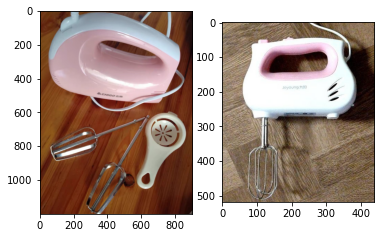

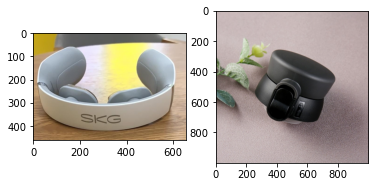

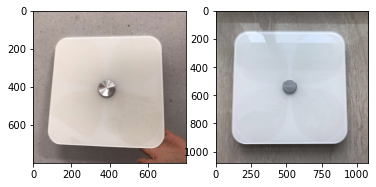

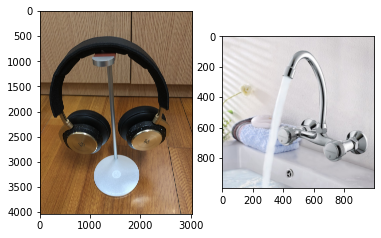

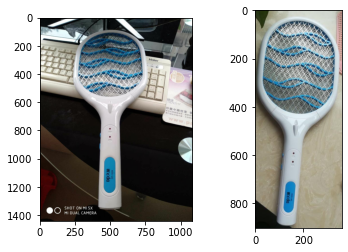

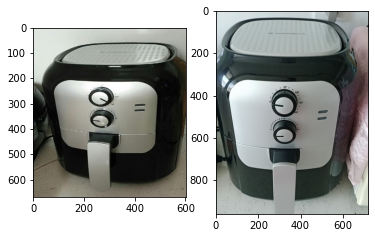

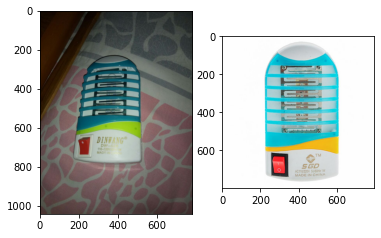

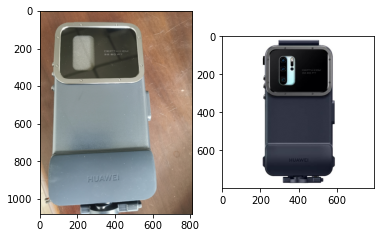

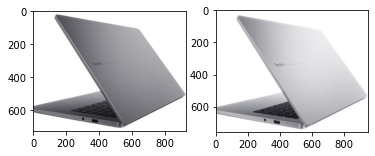

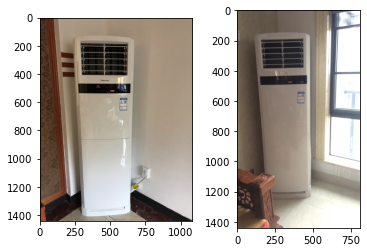

In [12]:
import faiss                   # make faiss available
index = faiss.IndexFlatL2(d)   # build the index
index.add(gallery_vector)                  # add vectors to the index

k = 10                          # we want to see 10 nearest neighbors

D, I = index.search(query_vector, k)     # actual search

result = ''
display_num = 10
for indices, distances, q_fn in zip(I, D, query_fns):
    line = q_fn+',{'
    
    # Visualization
    if display_num > 0:
        q_img = cv2.imread(os.path.join(TEST_DATASET_PATH, 'query', q_fn))[...,::-1].copy()
        g_img = cv2.imread(os.path.join(TEST_DATASET_PATH, 'gallery', gallery_fns[indices[0]]))[...,::-1].copy()
        f = plt.figure()
        f.add_subplot(1,2,1)
        plt.imshow(q_img)
        f.add_subplot(1,2,2)
        plt.imshow(g_img)
        plt.show()
        display_num -= 1
    # Visualization done     
    
    for i, dis in zip(indices, distances):
        #print(_d)
        # if dis-distances[0] > 200:
        #    break
        line+=gallery_fns[i]+','
    line = line[:-1]+'}\n'
    result+=line

In [14]:
with open('submission2020_0912_night.csv', 'a') as f:
    f.truncate(0)
    f.write(result)
    f.close()

In [5]:
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from glob import glob
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
import os
import copy
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import cv2
import numpy as np
from tqdm import tqdm
TRAIN_DATASET_PATH = '/home/meirtz/Desktop/huawei_comp/dataset/train_data'
IMG_SIZE = (512, 512)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class PadResize(object):
    def __init__(self,size):
        self.interpolation = Image.BILINEAR
        self.padding_v = [0, 0, 0]
        self.size = size
    def __call__(self, img):
        target_size = self.size
        padding_v = tuple(self.padding_v)
        interpolation = self.interpolation
        w, h = img.size
        if w > h:
            img = img.resize((int(target_size), int(h * target_size * 1.0 / w)), interpolation)
        else:
            img = img.resize((int(w * target_size * 1.0 / h), int(target_size)), interpolation)

        ret_img = Image.new("RGB", (target_size, target_size), padding_v)
        w, h = img.size
        st_w = int((ret_img.size[0] - w) / 2.0)
        st_h = int((ret_img.size[1] - h) / 2.0)
        ret_img.paste(img, (st_w, st_h))
        return ret_img

class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, image_fns, label_dict, data_transforms):
        self.image_fns = image_fns
        self.label_dict= label_dict
        self.transforms = data_transforms
    
    def __getitem__(self, index):
        label = self.label_dict[self.image_fns[index].split('/')[-2]]
        image = Image.open(self.image_fns[index]).convert("RGB")
#         image = np.asarray(image)
#         r,g,b = np.mean(image, axis=(0,1))
#         bkg_image = np.stack([
#             np.array(IMG_SIZE).fill(r),
#             np.array(IMG_SIZE).fill(g),
#             np.array(IMG_SIZE).fill(b)
#                      ])
#         bkg_image = Image.fromarray(np.zeros((IMG_SIZE[0], IMG_SIZE[1], 3)).astype(np.uint8))
#         print(bkg_image.size)
#         (h, w) = image.size
#         if h > w:
#             ratio = IMG_SIZE[1]/h
#             new_h = int(h*ratio)
#             new_w = int(w*ratio)
#             image = image.resize((new_h, new_w), Image.BICUBIC)
#         else:
#             ratio = IMG_SIZE[0]/w
#             new_h = int(h*ratio)
#             new_w = int(w*ratio)
#             image = image.resize((new_h, new_w), Image.BICUBIC)
#         bkg_image.paste(image, ((IMG_SIZE[0]-new_h)//2, ((IMG_SIZE[1]-new_w)//2)))
        
        image = self.transforms(image)
        return image, label
    
    def __len__(self):
        return len(self.image_fns)
image_fns = glob(os.path.join(TRAIN_DATASET_PATH, '*', '*.*'))
label_names = [s.split('/')[-2] for s in image_fns]
unique_labels = list(set(label_names))
unique_labels.sort()
id_labels = {_id:name for name, _id in enumerate(unique_labels)}

NUM_CLASSES = len(unique_labels)

In [27]:
train_transform = transforms.Compose([
     transforms.Scale(IMG_SIZE[0]),
#      transforms.CenterCrop(IMG_SIZE[0]),
#      transforms.RandomHorizontalFlip(p=0.5),
     transforms.ColorJitter(brightness=0.5, contrast=0.5,saturation=0.5),
     PadResize(IMG_SIZE[0]),
     transforms.RandomRotation((-30, 30)),
#      transforms.ColorJitter(brightness=0.5, contrast=0.5,saturation=0.5),
     transforms.ToTensor(),])
     #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),])

In [28]:
train_fns, val_fns = train_test_split(image_fns, test_size=0.1, shuffle=True)
train_dataset = ImageDataset(train_fns, id_labels, train_transform)

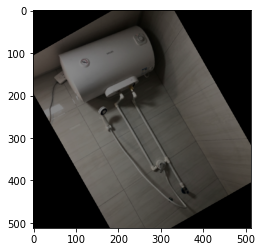

In [29]:
index = 6787
_,w,h = train_dataset[index][0].size()
plt.imshow(train_dataset[index][0].permute(1,2,0))

In [9]:
# hub_model = torch.hub.load('moskomule/senet.pytorch',
#                           'se_resnet50',
#                           pretrained=True)
# hub_model.eval()

Using cache found in /home/meirtz/.cache/torch/hub/moskomule_senet.pytorch_master


In [1]:
# from efficientnet_pytorch import EfficientNet
# model = EfficientNet.from_pretrained('efficientnet-b5')
# # model.eval()

In [2]:
from senet import Baseline
model = Baseline(3094,
                 1,
                 '/home/meirtz/.cache/torch/hub/checkpoints/se_resnext50_32x4d-a260b3a4.pth',
                 'bnneck',
                 'after',
                 'se_resnext50',
                 'imagenet'
                )

Loading pretrained ImageNet model......


In [3]:
model.eval()


Baseline(
  (base): SENet(
    (layer0): Sequential(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    )
    (layer1): Sequential(
      (0): SEResNeXtBottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReL